# Wasserstein generative adversarial network with Gradient Penalty (WGAN-GP)

In [1]:
# Importing required modules

import os
import functools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm
import time
from IPython import display
from tensorflow import keras 
from tensorflow.keras.layers import *
from pathlib import Path
from numba import cuda 
import tensorflow as tf
#device = cuda.get_current_device()
#device.reset()

In [2]:
# Emabling memory growth for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Setting the path for the data, and checking whether right folder is identified
path = Path("C:/Users/david/Desktop/DL Project 2/GAN/artists/artist1")
len(os.listdir(path))

877

# Setting up the training data and converting to right format

In [5]:
img_fn = [str(path/fn) for fn in os.listdir(path)]

In [6]:
# create tensorflow dataset 
dataset = tf.data.Dataset.from_tensor_slices(img_fn)

In [7]:
# function for preprocessing the images
def preprocess(fn):
    img = tf.io.read_file(fn)
    img = tf.image.decode_jpeg(img, 3)
    img = tf.cast(img, dtype=tf.float32)
    img = (img - 127.5) / 127.5
    img = tf.image.resize(img, (128, 128))
    return img

In [8]:
# preprocessing data
dataset = dataset.map(preprocess, num_parallel_calls=-1).cache()

In [9]:
# setting up dataset, and checking transformed original images (128x128)
dataset = dataset.shuffle(877).batch(32, drop_remainder=True)

In [10]:
dataset = dataset.prefetch(32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


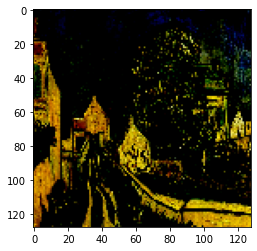

In [11]:
plt.imshow(next(dataset.as_numpy_iterator())[31])

# Setting up the models

In [16]:
# setting up the weight clipping function (to make sure parameters lie in a compact space, also advised in original WGAN paper)
class WeightClipping(keras.constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
    def __call__(self, weights):
        return tf.clip_by_value(weights, -self.clip_value, self.clip_value)

In [17]:
# Setting up the convolutional layers (used for building the models later)
class ConvLayer(Layer):
    def __init__(self, nf, ks, strides=2, padding='same', constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.conv = Conv2D(nf, ks, strides=strides, padding=padding,
                           kernel_initializer='he_normal', kernel_constraint=constraint, use_bias=False)
#         self.bn = BatchNormalization()
        self.norm = LayerNormalization()
        self.act = LeakyReLU(0.2)
        
    def call(self, X):
        X = self.act(self.conv(X))
        return self.norm(X)
    
def conv_layer(nf, ks, strides=2, padding='same'):
    conv = Conv2D(nf, ks, strides=strides, padding=padding, use_bias=False)
    bn = BatchNormalization()
    act = LeakyReLU(0.2)
    return keras.Sequential([conv, act, bn])

In [18]:
# building the discriminator (or critic in this case): 6 conv2D layers, kernel size 4x4, stride 2x2, same padding
def critic(input_shape=(128, 128, 3), dim=128, n_downsamplings=5):
    h = inputs = keras.Input(shape=input_shape)
    # 1: downsamplings, 128x128| -> 64x64 -> 32x32 -> 16x16 -> 8x8 -> 4x4
    h = ConvLayer(dim, 4, strides=2, padding='same')(h)
    for i in range(n_downsamplings - 1):
        d = min(dim * 2 ** (i + 1), dim * 8)
        h = ConvLayer(d, 4, strides=2, padding='same')(h)

    h = keras.layers.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer='he_normal')(h)
    h = Flatten()(h)
    return keras.Model(inputs=inputs, outputs=h)

In [19]:
# the discriminator model
d = critic()
d.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv_layer (ConvLayer)       (None, 64, 64, 128)       6400      
_________________________________________________________________
conv_layer_1 (ConvLayer)     (None, 32, 32, 256)       524800    
_________________________________________________________________
conv_layer_2 (ConvLayer)     (None, 16, 16, 512)       2098176   
_________________________________________________________________
conv_layer_3 (ConvLayer)     (None, 8, 8, 1024)        8390656   
_________________________________________________________________
conv_layer_4 (ConvLayer)     (None, 4, 4, 1024)        16779264  
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 1)           16385 

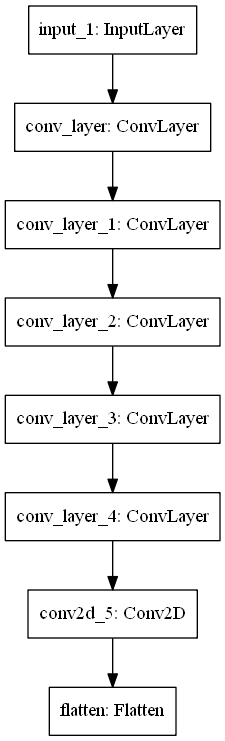

In [20]:
# Visualizing the discriminator model
tf.keras.utils.plot_model(
    d,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [21]:
# defining upsampling (deconvolutional) layers (used for building the generator)
class UpsampleBlock(Layer):
    def __init__(self, nf, ks, strides=2, padding='same', constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.conv_transpose = Conv2DTranspose(nf, ks, strides=strides, padding=padding, 
                                              kernel_initializer='he_normal', kernel_constraint=constraint)
        self.norm = LayerNormalization()
        self.act = ReLU()
        
    def call(self, X):
        X = self.act(self.conv_transpose(X))
        return self.norm(X)
    
def deconv_layer( nf, ks, strides=2, padding='same'):
    conv_transpose = Conv2DTranspose(nf, ks, strides=strides, padding=padding)
    bn = BatchNormalization()
    act = ReLU()
    return keras.Sequential([conv_transpose, act, bn])

In [22]:
# building the generator with 6 deconvolutional layers, kernel size 4x4, stride 2x2, sane padding
def generator(input_shape=(1, 1, 128), output_channels=3, dim=128, n_upsamplings=5):
    h = inputs = keras.Input(shape=input_shape)
    d = min(dim * 2 ** (n_upsamplings - 1), dim * 8)
    h = UpsampleBlock(d, 4, strides=1, padding='valid')(h)
    
    #  upsamplings, 4x4| -> 8x8 -> 16x16 -> 32x32 -> 64x64-> 128x128
    for i in range(n_upsamplings - 1):
        d = min(dim * 2 ** (n_upsamplings - 2 - i), dim * 8)
        h = UpsampleBlock(d, 4, strides=2, padding='same')(h)
        
    h = keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same',
                                     kernel_initializer='he_normal')(h)
    h = keras.layers.Activation('tanh')(h)

    return keras.Model(inputs=inputs, outputs=h)

In [23]:
# creating the generator and showing structure
g = generator()
g.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 128)]       0         
_________________________________________________________________
upsample_block (UpsampleBloc (None, 4, 4, 1024)        2100224   
_________________________________________________________________
upsample_block_1 (UpsampleBl (None, 8, 8, 1024)        16780288  
_________________________________________________________________
upsample_block_2 (UpsampleBl (None, 16, 16, 512)       8390144   
_________________________________________________________________
upsample_block_3 (UpsampleBl (None, 32, 32, 256)       2097920   
_________________________________________________________________
upsample_block_4 (UpsampleBl (None, 64, 64, 128)       524672    
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 128, 128, 3)       6147

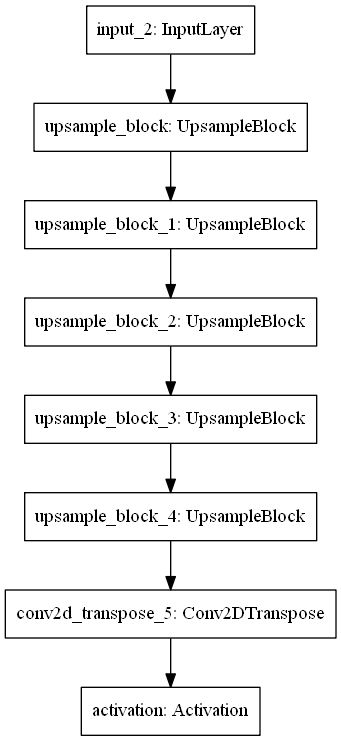

In [24]:
# Visualizing the generator model
tf.keras.utils.plot_model(
    g,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

# Setting up the training procedure

In [25]:
# Wasserstein loss 
# discriminator loss
def d_loss(real, fake):
    real_loss = -tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
    return real_loss + fake_loss
# generator loss
def g_loss(fake):
    return - tf.reduce_mean(fake)

In [26]:
# creating the gradient penalty (to be added to the training procedure)
@tf.function
def gradient_penalty(model, real, fake):
    shape = [tf.shape(real)[0]] + [1, 1, 1]
    alpha = tf.random.uniform(shape=shape, minval=0, maxval=1)
    interpolated = alpha * real  + (1-alpha) * fake
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = model(interpolated)
    grad = tape.gradient(pred, interpolated)
    norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [27]:
# Setting up basics (due to GPU memory limitations a batch size of 32 is ideal)
EPOCHS = 100
BATCH_SIZE = 32
noise_dim = 128

In [28]:
# Adam Optimizer used for training both models 
optD = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0, beta_2=0.9)
optG = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0, beta_2=0.9)

In [29]:
# Setting upt the separat training procedures

# training procedure for discriminator
@tf.function
def trainD(real):
    noise = tf.random.normal((BATCH_SIZE, 1, 1, noise_dim))
    with tf.GradientTape() as tape:
        fake_images = g(noise, training=True)
        real_output = d(real, training=True)
        fake_output = d(fake_images, training=True)
        gp_loss = gradient_penalty(functools.partial(d, training=True), real, fake_images)
        loss = d_loss(real_output, fake_output)
        disc_loss = loss + 10 * gp_loss
        
    d_grad = tape.gradient(disc_loss, d.trainable_variables)
    optD.apply_gradients(zip(d_grad, d.trainable_variables))
    
# training procedure for generator    
@tf.function
def trainG():
    noise = tf.random.normal((BATCH_SIZE, 1, 1, noise_dim))
    with tf.GradientTape() as tape:
        generated_images = g(noise, training=True)
        loss = g_loss(d(generated_images))
        
    g_grad = tape.gradient(loss, g.trainable_variables)
    optG.apply_gradients(zip(g_grad, g.trainable_variables))

In [30]:
seed = tf.random.normal((16, 1, 1, 128))


In [40]:
# function for generating and saving images
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig, ax = plt.subplots(4, 4, figsize=(10,10))

    for i, a in enumerate(ax.flat):
        a.imshow(predictions[i, :, :, :])
        a.axis('off')
    plt.savefig("C:/Users/david/Desktop/DL Project 2/GAN/WGAN FINAL/Generated WGAN FINAL14/train_image" + str(epoch) + ".png")
    plt.show()
    



In [34]:
# defining the training sequence tying both models together and displaying output after every iteration
def train(dataset, epochs):
    for epoch in range(epochs):
        seed = tf.random.normal((16, 1, 1, 128))
        start = time.time()

        for image_batch in tqdm.tqdm(dataset, total=877//BATCH_SIZE):
          # train_step(image_batch)
            trainD(image_batch)
            if optD.iterations.numpy() % 5 == 0:
                trainG()

        display.clear_output(wait=True)
        generate_images(g, epoch + 1, seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Training and investigating the results, comparing to original

In [35]:
# loading model weights as the models were trained in separate sessions
g.load_weights("WGAN_VANG_2000r_G.hdf5")
d.load_weights("WGAN_VANG_2000r_D.hdf5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

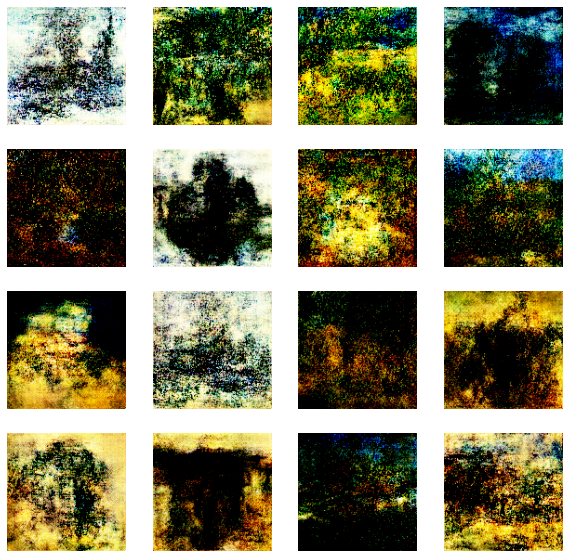

Time for epoch 10 is 23.626044511795044 sec


In [36]:
# training the models (for 10 epochs in this case)
train(dataset, 10)

In [110]:
# save model weights
g.save_weights("WGAN_VANG_2000r_G.hdf5")

In [111]:
d.save_weights("WGAN_VANG_2000r_D.hdf5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


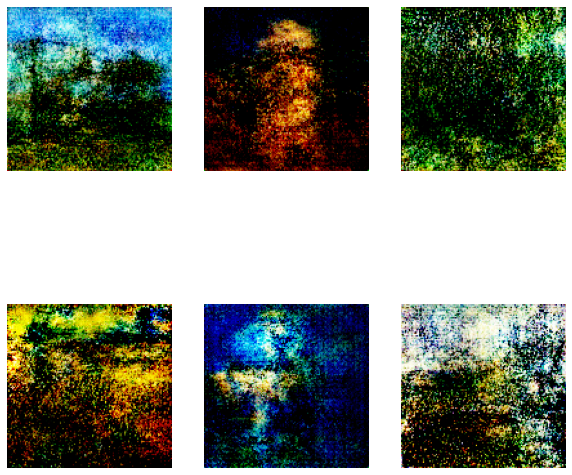

In [41]:
# generate images with the generator after training
generate_images(g, 2002, tf.random.normal([32, 1, 1, 128]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


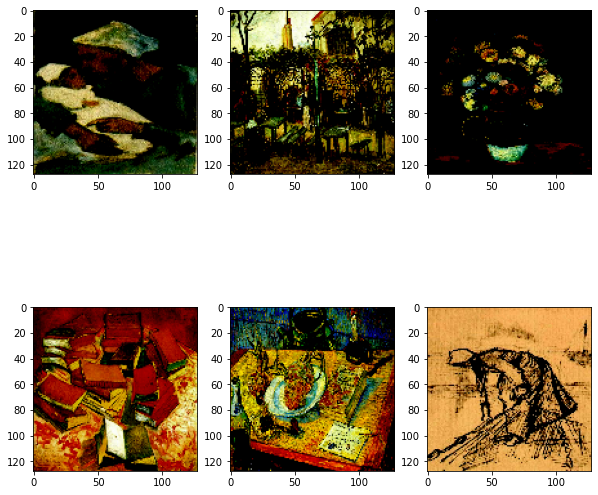

In [45]:
# generate images from the original dataset in a transformed format (128x128)
w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    img = next(dataset.as_numpy_iterator())[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    fig.savefig("original.png")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


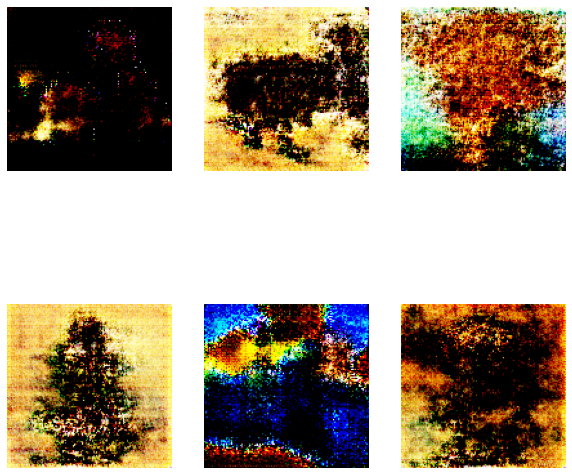

In [43]:
# loading model weights as the models were trained in separate sessions
g.load_weights("WGAN_VANG_500r_G.hdf5")
# generate images with the generator after training
generate_images(g, 300, tf.random.normal([32, 1, 1, 128]))